In [0]:
import modeling
import optimization
import run_classifier
import tokenization

In [0]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/optimization.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/run_classifier.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py 

--2019-11-27 05:32:45--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  69.3MB/s    in 5.6s    

2019-11-27 05:32:51 (69.3 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

--2019-11-27 05:32:54--  https://raw.githubusercontent.com/google-research/bert/master/modeling.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37922 (37K) [te

In [0]:
import zipfile
folder = 'model_folder'
with zipfile.ZipFile("uncased_L-12_H-768_A-12.zip","r") as zip_ref:
    zip_ref.extractall(folder)

In [0]:
BERT_MODEL = 'uncased_L-12_H-768_A-12'
BERT_PRETRAINED_DIR = f'{folder}/uncased_L-12_H-768_A-12'
OUTPUT_DIR = f'{folder}/outputs'
print(f'>> Model output directory: {OUTPUT_DIR}')
print(f'>>  BERT pretrained directory: {BERT_PRETRAINED_DIR}')

>> Model output directory: model_folder/outputs
>>  BERT pretrained directory: model_folder/uncased_L-12_H-768_A-12


In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [0]:
from google.colab import files
uploaded = files.upload()

Saving drugsComTest_raw.csv to drugsComTest_raw.csv


In [0]:
#Open drugreview files
import io
df_train=pd.read_csv(io.StringIO(uploaded["drugsComTest_raw.csv"].decode('utf-8')))
print("Train Data format " ,df_train.head())
print("Train Data shape ",df_train.shape)
print("Condition count in Train dataset ", df_train['condition'].value_counts())
df_train_cond_rev=df_train[['condition','review']].copy()
df_temp=df_train_cond_rev[pd.notnull(df_train_cond_rev['review'])]
df_train_fil=df_temp[pd.notnull(df_temp['condition'])]
print("Dataset with columns Condition and review" , df_train_fil)
print("Dataset with columns Condition and review dimension " ,df_train_fil.shape)


Train Data format     uniqueID         drugName  ...       date usefulCount
0    163740      Mirtazapine  ...  28-Feb-12          22
1    206473       Mesalamine  ...  17-May-09          17
2    159672          Bactrim  ...  29-Sep-17           3
3     39293         Contrave  ...   5-Mar-17          35
4     97768  Cyclafem 1 / 35  ...  22-Oct-15           4

[5 rows x 7 columns]
Train Data shape  (53766, 7)
Condition count in Train dataset  Birth Control                                  9648
Depression                                     3095
Pain                                           2100
Anxiety                                        1908
Acne                                           1847
                                               ... 
37</span> users found this comment helpful.       1
Jet Lag                                           1
Pemphigoid                                        1
Keratitis                                         1
Cachexia                          

Birth Control                                  9648
Depression                                     3095
Pain                                           2100
Anxiety                                        1908
Acne                                           1847
                                               ... 
37</span> users found this comment helpful.       1
Jet Lag                                           1
Pemphigoid                                        1
Keratitis                                         1
Cachexia                                          1
Name: condition, Length: 708, dtype: int64


Text(0.5, 1.0, 'Top40 : The number of reviews per condition.')

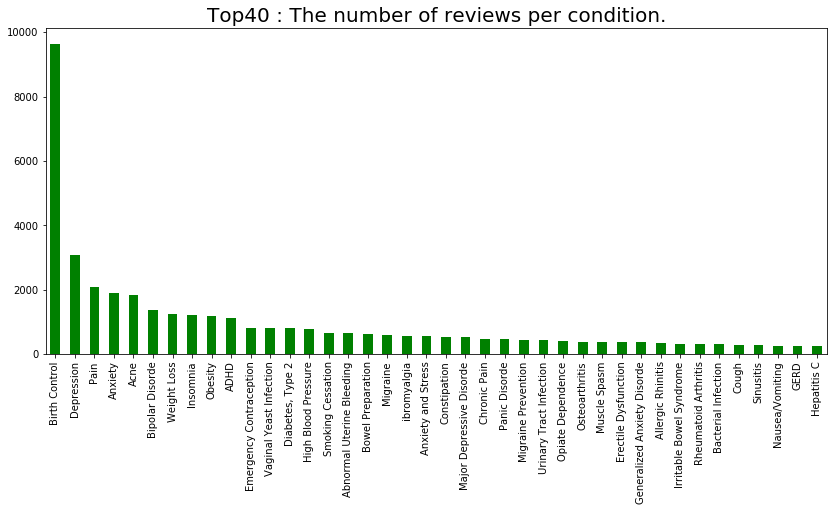

In [0]:
# Data plot based on review and condition
df_condition=df_train_fil.condition.value_counts()
print(df_condition)
df_condition[0:40].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top40 : The number of reviews per condition.", fontsize = 20)


In [0]:
df_comment = df_train_fil[df_train_fil['condition'].str.contains('comment')]
df_comment

,condition,review
136,12</span> users found this comment helpful.,"""I was really worried at first because of all ..."
211,0</span> users found this comment helpful.,"""I have been off of birth control for 2 years...."
348,6</span> users found this comment helpful.,"""This medicine is great, our patients no longe..."
368,24</span> users found this comment helpful.,"""I&#039;ve been taking this since January 2013..."
572,9</span> users found this comment helpful.,"""I took the pill Friday night and went to bed...."
...,...,...
52443,3</span> users found this comment helpful.,"""I have been taking this pill for less than a ..."
53116,5</span> users found this comment helpful.,"""I got the Mirena put in last month. And holy ..."
53287,21</span> users found this comment helpful.,"""It was a nightmare.I had the worse side effec..."
53353,28</span> users found this comment helpful.,"""My 10 year old son took Dulera for asthma. I..."


In [0]:
# Dropping rows that contain incorrect information 

df_train_fil = df_train_fil[~df_train_fil['condition'].str.contains('comment')]
print(df_train_fil.shape)

(53200, 2)


In [0]:
value_counts=df_train_fil['condition'].value_counts()
# Select the values where the count is less than 3 (or 5 if you like)
to_remove = value_counts[value_counts <= 100].index
# Keep rows where the city column is not in to_remove
df_train_fil = df_train_fil[~df_train_fil.condition.isin(to_remove)]
print(" Dataset after removal",df_train_fil.shape)
df_train_fil.condition.value_counts()

 Dataset after removal (45312, 2)


Birth Control                 9648
Depression                    3095
Pain                          2100
Anxiety                       1908
Acne                          1847
                              ... 
Cough and Nasal Congestion     113
Psoriatic Arthritis            112
Opiate Withdrawal              107
Cold Sores                     105
Inflammatory Conditions        103
Name: condition, Length: 79, dtype: int64

In [0]:
#df2_train=df_train_fil
df2_train = df_train_fil.sample(frac=0.5, replace=True, random_state=1).copy()

In [0]:
print(df2_train.columns.values)
df2_train.head()

['condition' 'review']


,condition,review
39199,Anxiety,"""My experience with it. The medicine works gr..."
14503,Abnormal Uterine Bleeding,"""I switched to this pill about 7-8 months ago ..."
6169,Migraine Prevention,"""Have been taking this for other conditions. S..."
38621,Birth Control,"""I can&#039;t speak on how well this birth con..."
51911,Migraine Prevention,"""I never had &quot;headache&quot; in my life u..."


In [0]:
#Clean review comments
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@\d+]#')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z00-99 #+_]')
add_stop = ['', ' ', 'say', 's', 'u', 'ap', 'afp', '...', 'n', '\\','this','will','doctor','took','got','month','an','weight','if','one','week','when','more','are','weeks','are','would','just','feel','day',
 'im','though','daily','found','daily','found','give','7','gained','happy','sure','told','less','gave','three',
 'side','taking','ive','years','first','effects','take','started','like','months','get','days','time','2','feel','would','3',
 'back', 'also','dont','since', 'also','dont','since', 'cant','stop','morning','however','taken','within','see''good','night',
 'even','year','great','ago','4','tried','little','5','dose','used','worked','1','getting','could','10','almost','put','6','use',
 'nothing','far','helped','normal','gain','recommend','without','long','thing','make','many','noticed','said','ood','best',
 'thought','gone','working','couldnt','anything','something','spotting','things','people','second','need','20','way','half',
 'start','another','completely','wasnt','everything','8','face','bit','high','worth','definitely','pretty','decided','actually',
 'lbs','effective','past','today','helps','heavy','new','may','doesnt','30','minutes','15','problem','dry','came','reviews','shot','issues','trying','switched','depressed','12','full','sometimes','find','meds','change','anyone','caused','thats','results','done','increased','twice','energy','fine','several','hard','read','given','pressure','come','clear','eating','already','insurance','everyone','dosage','mouth','amazing','id','enough','wanted','overall','maybe','began','really','still','never','much','work','went','two','didnt','go','made','works','going','mg','hours','last','ever','lost','lot','try','think','stopped',
 'away','know','times','always','havent','next','due','want','around','experienced','finally','able','right','later','different','hour','keep','dr','changed','makes','least','else','difference','seems','needed','product',
 'point','soon','absolutely','anymore','usually','drink','free','stay','became','recently','awful','small','hoping','believe','felt','better','good','every','well','help','feeling','prescribed','severe','experience','using','effect','worse','body','old','love','see','symptoms','eat','drive','problems','light','starting','insertion','attacks','hope','bed','plan','negative','crazy','major','9','whole','gotten','quit','removed','extreme','food','pack','lasted','end','patch','everyday','constant','person','25','reason','others','medications','thoughts','24','yet','tell','reading','etc','regular','although','suffered','cause','10mg','along','asleep','wake','remember','medicines','100','doctors','hair','left','immediately','hurt','part','constantly','school','per','highly','burning','mind','break','positive','b','super','slight','big','short','head','notice','probably','cycle','deal','cleared','either','woke','seem','wish','increase','wait','boyfriend','let','four','50','18','wouldnt','scared','23','20mg','quite','stuff','continue','takes','thinking','literally','worry','beginning','might','recommended','treatment','early','plus','experiencing','taste','home','seemed','huge','ended','kept','easy','husband','doc','hungry','suffer','crying','wont','third','switch','except','become','isnt','prescription','making','16','coming','family','40','fall','yes','goes','luck','quickly','entire','2015','currently','looking','fast','glad','fatigue','attack','please','straight','yrs','2nd','can','not','thank','dreams','withdrawal','trouble','3rd','cream','happened','fact','function','care','often','kind','50mg','hate','kids','amount','late','especially','instead','gets','switching','wonderful','issue','changes','losing','chest','saved','broke','level','worried','live','totally','loved','14','lighter','type','active','nearly','age','prior','feels','intense','real','1st','son','45','rather','baby','decreased','improved','slowly','someone','focus','self','lots','size','normally','5mg','hospital','irregular','six','yesterday','nervous','rest','cry','uncomfortable','supposed','hopefully','guess','drinking','procedure','knew','called','improvement','giving','11','34','youre','walk','form','asked','slightly','developed','bathroom','expensive','suggested','17','look','okay','sleepy','ok','eventually','course','add','2016','knee','stick','must','brand','five','sensitive','health','wonders','minor','child','comes','none','breakouts','hasnt','adderall','saw','cost','review','unfortunately','red','100mg','leave','affects','occasional','helping','hot','breakthrough','serious','possible','usual','zero','single','pay','perfect','levels','hell','nights','sad','legs','total','friends','handle','doses','seen','difficult','prep','easily','13','throughout','slept','minimal','god','social','continued','turned','mine','reduced','seeing','strong','term','ready','truly','upset','happen','lasts','unbearable','wrong','rid','mostly','evening','says','unprotected','march','case','children','place','25mg','vyvanse','moderate','awesome','pm','reaction','post','60','female','causing','higher','easier'
           'hands',
 'realized',
 'process',
 'sprintec',
 'appointment',
 'following',
 'stopping',
 'july',
 'spot',
 'talk',
 'belviq',
 'hit',
 'test',
 'system',
 'rate',
 'hrs',
 'move',
 'june',
 '21',
 'inside',
 'stayed',
 '75',
 'house',
 'ones',
 'gives',
 'discomfort',
 'awake',
 'moods',
 '30mg',
 'exactly',
 'anyway',
 'college',
 'hardly',
 'tablet',
 'quick',
 'extra',
 'close',
 '19',
 'nice',
 'area',
 'forget',
 'added',
 'heard',
 '40mg',
 '35',
 'finished',
 'wear',
 'middle',
 'unable',
 'thanks',
 'emotions',
 'waking',
 'august',
 'run',
 'method',
 'pms',
 'basically',
 'walking',
 'miss',
 'matter',
 'initially',
 'keeps',
 'january',
 'ate',
 'changing',
 'previously',
 'falling',
 'non',
 'general',
 'ask',
 'breaking',
 'causes',
 '2014',
 'april',
 'update',
 'expected',
 '4th',
 'call',
 'compared',
 'waiting',
 'idea',
 'complete',
 'gaining',
 'considering',
 'helpful',
 'decrease',
 'experiences',
 'mean',
 'subsided',
 'placed',
 'including',
 'tomorrow',
 'ten',
 'check',
 'otherwise',
 'cover',
 'besides',
 'money',
 'name',
 '90',
 'option',
 'affect',
 'enjoy',
 'october',
 'significant',
 'excited',
 'top',
 'deep',
 'differently',
 '150',
 'cup',
 '22',
 'saying','oh','stuck','seriously','pleased','random','flow','dealing','28','clean','racing','bottle','dropped','initial','us','success','living','stand','realize','treat','shots','alone','150mg','looked','december','tender','vivid','occasionally','afterwards','chance','talking','theres','choice','multiple','bought','together','advice','motivation','friend','75mg','write','whatsoever','struggled','sit','world','somewhat','missed','slow','strange','prevent','decision','episodes','room','suggest','near','followed','begin','previous','quality','hated','november','significantly','mention','despite','male','understand','allergic','share','prescribe','greatly','forward','2017','price','similar','related','rarely','meal','finish','september','till','spent','returned','result','february','covered','downside','lasting','arent','200','disappeared','spots','mother','bigger','happens','benefits','important','80','wow','office','severely','manageable','state','wanting','mixed','toilet','26','foods','na','putting','staying','car','withdrawals','tests','adjust','site','keeping','unless','affected','regularly','main','market','effectiveness','concerta','gas','cried','drop','seconds','buy','looks','nurse','true','stories','biggest','dark','afternoon','min','1mg','fairly','sense','regulate','hunger','oral','concentrate','yr','tolerable','300','2013','set','focused','young','excellent','mess','thankful','incredibly','turn','fantastic','comments','medical','exhausted','cons','rough','15mg','300mg','preventing','moved','history','expect','driving','2x','minute','pros','finding','story','wash','56','lol','scale','clots','lay','struggling','moving','figured','follow','ease','lucky','needs','received','flashes','increasing','immediate','shorter','breakout','difficulty','relieved','aware','complaint','ability','suddenly','brown','starts','27','hadnt','empty','online','edge','failed',]

STOPWORDS = set(stopwords.words('english'))
stop_words=STOPWORDS.union(add_stop)
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in stop_words) # delete stopwors from text
    return text
    
df2_train['review'] = df2_train['review'].apply(clean_text)
#print_plot(10)


In [0]:
# Create a new column 'category_id' with encoded categories 
df2_train['condition_id'] = df2_train['condition'].factorize()[0]
category_id_df = df2_train[['condition', 'condition_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['condition_id', 'condition']].values)

# New dataframe
df2_train.head()

,condition,review,condition_id
39199,Anxiety,medicine itch relief pruritis anxiety graves d...,0
14503,Abnormal Uterine Bleeding,pill anxiety heightened angry libido sleep tir...,1
6169,Migraine Prevention,conditions spotty vision migraines timestopped...,2
38621,Birth Control,speak birth control placement beforehand horro...,3
51911,Migraine Prevention,headache life migraine beyond pain debilitatin...,2


In [0]:
df3=pd.DataFrame()
df3["Text"] = df2_train["review"]
df3["Label"] = df2_train["condition_id"]
#df3=df3[0:200]
#df2 = df[:2000]
print(df3)

                                                    Text  Label
39199  medicine itch relief pruritis anxiety graves d...      0
14503  pill anxiety heightened angry libido sleep tir...      1
6169   conditions spotty vision migraines timestopped...      2
38621  speak birth control placement beforehand horro...      3
51911  headache life migraine beyond pain debilitatin...      2
...                                                  ...    ...
2235   fiorinal pain medicine headache degree satisfa...     59
24421  stumbled upon page mild yi life omg yi bad sle...     28
6055   farxiga numbers fives sixes noticeable dizzine...     16
35034  effexor buspirone lexapro prozac participate i...     49
1431   nsaids cymbalta pain depression horrible worst...     19

[22656 rows x 2 columns]


In [0]:
X_train, X_test, y_train, y_test = train_test_split(df3["Text"].values, df3["Label"].values, test_size=0.2, random_state=42)

In [0]:
import os
def create_examples(lines, set_type, labels=None):
#Generate data for the BERT model
    guid = f'{set_type}'
    examples = []
    if guid == 'train':
        for line, label in zip(lines, labels):
            text_a = line
            label = str(label)
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    else:
        for line in lines:
            text_a = line
            label = '0'
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

# Model Hyper Parameters
TRAIN_BATCH_SIZE = 4
EVAL_BATCH_SIZE = 1
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 3.0
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 250
# Model configs
SAVE_CHECKPOINTS_STEPS = 100000 #if you wish to finetune a model on a larger dataset, use larger interval
# each checpoint weights about 1,5gb
ITERATIONS_PER_LOOP = 100000
NUM_TPU_CORES = 8
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
DO_LOWER_CASE = BERT_MODEL.startswith('uncased')

label_list = [str(num) for num in range(80)]
##Anoop changes
print(label_list)
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)
train_examples = create_examples(X_train, 'train', labels=y_train)

tpu_cluster_resolver = None #Since training will happen on GPU, we won't need a cluster resolver
#TPUEstimator also supports training on CPU and GPU. You don't need to define a separate tf.estimator.Estimator.
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

num_train_steps = int(
    len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

model_fn = run_classifier.model_fn_builder(
    bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
    num_labels=len(label_list),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available  
    use_one_hot_embeddings=True)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available 
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79']
INFO:tensorflow:Using config: {'_model_dir': 'model_folder/outputs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribut

In [0]:
##Anoop changes
from datetime import time
print(label_list)
print('Please wait...')
train_features = run_classifier.convert_examples_to_features(
    train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
#print('>> Started training at {} '.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_examples)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
#print('>> Finished training at {}'.format(datetime.datetime.now()))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79']
Please wait...
INFO:tensorflow:Writing example 0 of 18124
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: train
INFO:tensorflow:tokens: [CLS] drug problematic de ##hy ##dra ##tion shifting sleep awakening ex ##cr ##uc ##iating ##ly painful leg foot cr ##amps thoroughly awakened poured sand eyes eyes de ##hy ##dra ##ted attempted address de ##hy ##dra ##tion gallon water water bed ##time ur ##ination glucose readings in ##vo ##kan ##a sugar star ##ch diet exercise brought numbers in ##vo ##kan ##a [SEP]
INFO:tensorflow

In [0]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    print(params)
    #batch_size = 500
    batch_size=8
    num_examples = len(features)

    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

In [0]:
predict_examples = create_examples(X_test, 'test')

predict_features = run_classifier.convert_examples_to_features(
    predict_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

predict_input_fn = input_fn_builder(
    features=predict_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

result = estimator.predict(input_fn=predict_input_fn)

INFO:tensorflow:Writing example 0 of 4532
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: test
INFO:tensorflow:tokens: [CLS] minas ##tri ##n fe cr ##amps period period horrible cr ##amps period teenager [SEP]
INFO:tensorflow:input_ids: 101 21750 18886 2078 10768 13675 25167 2558 2558 9202 13675 25167 2558 10563 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [0]:
preds = []
for prediction in result:
      preds.append(np.argmax(prediction['probabilities']))

{}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:*** Features ***
INFO:tensorflow:  name = input_ids, shape = (?, 250)
INFO:tensorflow:  name = input_mask, shape = (?, 250)
INFO:tensorflow:  name = label_ids, shape = (?,)
INFO:tensorflow:  name = segment_ids, shape = (?, 250)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (30522, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encode

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
print("Accuracy of BERT is:",accuracy_score(y_test,preds))

Accuracy of BERT is: 0.6630626654898499


In [0]:
df3[0:20]

,Text,Label
39199,medicine itch relief pruritis anxiety graves d...,0
14503,pill anxiety heightened angry libido sleep tir...,1
6169,conditions spotty vision migraines timestopped...,2
38621,speak birth control placement beforehand horro...,3
51911,headache life migraine beyond pain debilitatin...,2
9260,girlfriend cramps abnormal bleeding leaves woo...,3
25524,searching medication goodness,4
39088,anxiety junior paxil appetite monotonous pound...,5
24546,wellbutrin zoloft zoloft unfortunate wellbutri...,4
9187,anxiety calms stress,0


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.47      0.73      0.57       202
           1       0.41      0.20      0.27        55
           2       0.44      0.39      0.41        36
           3       0.89      0.96      0.92       996
           4       0.54      0.79      0.64       325
           5       0.00      0.00      0.00        35
           6       0.00      0.00      0.00         5
           7       0.55      0.61      0.58        46
           8       0.68      0.74      0.71       105
           9       0.67      0.07      0.13        27
          10       0.33      0.02      0.05        41
          11       0.54      0.87      0.66       219
          12       1.00      0.08      0.14        26
          13       0.81      0.86      0.83        85
          14       0.00      0.00      0.00        66
          15       0.90      0.85      0.87       210
          16       0.63      0.74      0.68        78
          17       0.71    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
